In [252]:
import pandas as pd

file1 = "EP6_RCVs_2022_06_13.xlsx"
file2 = "EP6_Voted docs.xlsx"
file3 = "EP7_RCVs_2014_06_19.xlsx"
file4 = "EP7_Voted docs.xlsx"
file5 = "EP8_RCVs_2019_06_25.xlsx"
file6 = "EP8_Voted docs.xlsx"
file7 = "EP9_RCVs_2022_06_22.xlsx"
file8 = "EP9_Voted docs.xlsx"

def read_excel_to_df(file, usecols=None, sheet=None):
    df = pd.read_excel(file, usecols=usecols)
    return df

def read_pickle_to_df(file):
    return pd.read_pickle(file)

def is_RCV_or_voted_docs(file):
    if "RCV" in file:
        return "RCV"
    elif "Voted docs" in file:
        return "Voted docs"
    
file_names = [
        file1,
        file2,
        file3,
        file4,
        file5,
        file6,
        file7,
        file8
    ]
   
# all files (if needed)
all_files = {file: is_RCV_or_voted_docs(file) for file in file_names}

In [253]:

def filter_data(df, meta_cols, start_col):
    vote_cols = df.columns[start_col:]
    return df[meta_cols + list(vote_cols)]


filesRCV = []
for file in all_files:
    if all_files[file] == "RCV":
        filesRCV.append(file)

raw_data = {}
for file in filesRCV:
    raw_data[file] = read_pickle_to_df("pickled_data/" + file + ".pkl")

for key, val in raw_data.items():
    pass#(key, val.columns)

meta_cols = ["Column2", "Column7", "Column8", "Column9"]
filtered_data_1 = filter_data(raw_data[file1], meta_cols, 10)
filtered_data_1 = filtered_data_1[2:]


filtered_data_1 = filtered_data_1.rename(columns={
    "Column2": "WebisteEpID",
    "Column7": "Country",
    "Column8": "Party",
    "Column9": "EPG"})

start_col = 4

new_columns = list(filtered_data_1.columns[:start_col]) + list(range(1, len(filtered_data_1.columns) - start_col + 1))
filtered_data_1.columns = new_columns
#rint("1 ", filtered_data_1["Party"])


meta_cols = ["MEP ID", "Country", "EPG"]
filtered_data_2 = filter_data(raw_data[file3], meta_cols, 9)
filtered_data_2 = filtered_data_2.rename(columns={
    "MEP ID": "WebisteEpID"})

#print("2 ", filtered_data_2.columns)

meta_cols = ["WebisteEpID", "Country", "EPG"]

filtered_data_3 = filter_data(raw_data[file5], meta_cols, 9)
#print("3 ",filtered_data_3.columns)

filtered_data_4 = filter_data(raw_data[file7], meta_cols, 10)
#print("4 ", filtered_data_4.columns)


In [254]:
""" Encoding from legend sheet:
0 - not a MEP
1 - for
2 - against
3 - abstention
4 - absent
5 - didn't vote
6 - motivated
"""

import numpy as np

def encode_votes(votes_categorical):
    votes_encoded = np.zeros_like(votes_categorical)

    votes_encoded[votes_categorical == 1] = 1   # for
    votes_encoded[votes_categorical == 2] = -1  # against
    return votes_encoded

def encode_votes_strict(votes_categorical):
    votes_encoded = np.ones_like(votes_categorical) * -1

    votes_encoded[votes_categorical == 1] = 1   # for is 1, everythingn else -1
    return votes_encoded


def compute_cosine_similarity_mtx(votes_encoded):
    norms = np.linalg.norm(votes_encoded, axis=1, keepdims=True)
    norms[norms == 0] = 1    # avoid division by zero

    votes_norm = votes_encoded / norms
    S = votes_norm @ votes_norm.T
    return S

def compute_MDS(S, k=1, eps=0.0):
    n = S.shape[0]

    evals, evecs = np.linalg.eigh(S)
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    # Keep only positive eigenvalues
    pos = evals > eps
    evals_pos = evals[pos]
    evecs_pos = evecs[:, pos]

    if evals_pos.size < k:
        raise ValueError(
            f"Not enough positive eigenvalues to build k={k} dims "
            f"(found {evals_pos.size}). Consider a different distance mapping or k."
        )

    Lk = np.diag(np.sqrt(evals_pos[:k]))
    Vk = evecs_pos[:, :k]
    explained = evals / evals.sum()
    print(explained[:5])

    # Coordinates: X = V_k * sqrt(Lambda_k)
    X = Vk @ Lk
    return X, evals

def process_and_compute_MDS(filtered_data, name):
    colors = filtered_data[["WebisteEpID", "Country", "EPG"]][:]

    # enforce string
    colors["EPG"] = colors["EPG"].fillna("Unknown").astype(str)
    colors["Country"] = colors["Country"].fillna("Unknown").astype(str)

    votes_categorical = np.array(filtered_data.loc[:, 1:])

    #compute similarity matrix for file3
    votes_encoded = encode_votes(votes_categorical)
    S = compute_cosine_similarity_mtx(votes_encoded)
    print(S.shape)

    X, evals = compute_MDS(S, k=2)
    print(X.shape)
    return {"name": name,
            "X": X,
            "evals": evals,
            "colors": colors
            }

def k_nearest_neighbors(S, k=20):
    n = S.shape[0]
    S = np.maximum(S, 0.0)

    W = np.zeros_like(S)

    for i in range(n):
        idx = np.argsort(S[i])[-k-1:-1]  # top-k neighbors 
        W[i, idx] = S[i, idx]

    # make graph symmetric
    W = np.maximum(W, W.T)

    return W

def spectral_embedding(votes, k=20):

    S = compute_cosine_similarity_mtx(votes)
    X, eigvals = build_graph(S, k=k)

    return X, eigvals

def compute_mean_of_groups_per_vote(votes, color):
    groups = set(color[1:])
    print(groups)

    group_means = {}
    group_std = {}
    for group in groups:
        mask = (color == group)
        group_means[group] = np.mean(votes[mask], axis=0)
        group_std[group] = np.std(votes[mask], axis=0)

    return group_means, group_std

def compute_diff_from_groupmean(votes, colors, groupmeans):
    votes_cp = votes.copy()
    for group, mean in groupmeans.items():
        mask = (colors == group)
        votes_cp[mask] = votes_cp[mask] - mean
    return votes_cp

def build_graph(S, k=20):
    n = S.shape[0]
    # build weights/edges matrix
    A = k_nearest_neighbors(S, k=k)

    # build degree matrix
    deg = A.sum(axis=1)
    print(deg)
    print(min(deg))

    eps = 1e-12
    D_inv_sqrt = np.diag(1.0 / (np.sqrt(deg)+ eps))
    L = np.eye(n) - D_inv_sqrt @ A @ D_inv_sqrt

    eigvals, eigvecs = np.linalg.eigh(L)

    X = eigvecs[:, 1:3]   # shape (n_meps, 2)

    return X, eigvals

def run_mean_comp(votes, colors, k=20):
    group_means, _ = compute_mean_of_groups_per_vote(votes, colors)
    votes_res = compute_diff_from_groupmean(votes, colors, group_means)

    S = compute_cosine_similarity_mtx(votes_res)
    #X, evals = compute_MDS(S, k=2)
    X, evals = build_graph(S, k=k)
   
    return X, evals

def cosine_sim_between_mean(votes, colors, groupmeans):
    norms = np.linalg.norm(votes, axis=1, keepdims=True)
    norms[norms == 0] = 1    # avoid division by zero

    votes_norm = votes / norms
    means_mat = np.ones_like(votes)

    for group, mean in groupmeans.items():
        mask = (colors == group)
        means_mat[mask] *= mean
    norms = np.linalg.norm(means_mat, axis=1, keepdims=True)
    norms[norms == 0] = 1

    means_mat_norm = means_mat / norms
    print(f"votes: {votes_norm.shape}, means: {means_mat_norm.shape}")
    S = np.sum(votes_norm * means_mat_norm, axis=1)    
    return S

def run_mean_sim(votes, colors, k=20):
    groupmeans, group_std = compute_mean_of_groups_per_vote(votes, colors)
    S = cosine_sim_between_mean(votes, colors, groupmeans)
    #X, evals = compute_MDS(S, k=2)
    X, evals = build_graph(S, k=k)
    return X, evals


filtered_datas = [filtered_data_1, filtered_data_2, filtered_data_3, filtered_data_4]
results = []

#for i, filtered_data in enumerate(filtered_datas):
result = process_and_compute_MDS(filtered_data_1, "mds")
#results.append(result)


#X, eigvals = spectral_embedding(filtered_data_1)
meta_cols = ["WebisteEpID", "Country", "EPG", "Party"]

colors = filtered_data_1[meta_cols][:]
vote_cols = filtered_data_1.columns.difference(
        meta_cols
    )
votes = np.array(filtered_data_1[vote_cols])
#votes_encoded = encode_votes_strict(votes)
votes_encoded = encode_votes(votes)

# enforce string
colors["EPG"] = colors["EPG"].fillna("Unknown").astype(str)
colors["Country"] = colors["Country"].fillna("Unknown").astype(str)

"""
X, evals = run_mean_sim(votes_encoded, colors["EPG"], k=50)
means_result = {"name": "means",
        "X": X,
        "evals": evals,
        "colors": colors
        }
"""
#k_nn = 5
ks = [5, 6, 7, 8, 9, 10, 15]
res_ks = {}
for k_nn in ks:
    #X, evals = run_mean_comp(votes_encoded, colors["EPG"], k=k_nn)
    X, evals = spectral_embedding(votes_encoded, k=k_nn)
    res_result = {"name": f"Spectral Analysis of Votes, with k={k_nn}",
                    "X": X,
                    "evals": evals,
                    "colors": colors
                    }
    res_ks[k_nn] = res_result

"""
X, eigvals = spectral_embedding(votes_encoded, k=k_nn)
graph_result = {"name": "graph_embedding",
                "X": X,
                "evals": eigvals,
                "colors": colors}
"""


(940, 940)
[0.30469185 0.12544249 0.04032333 0.02985219 0.02766367]
(940, 2)
[ 3.67277516  2.11451196  7.01303387  7.79900247  2.23293689  6.01964909
  4.88598899  9.21254974  3.3699671   4.03575376  4.55632402  3.1395441
  7.64702835  4.72245093 18.94477273  3.58965766  4.9116476   3.72512481
  7.77698533  4.44128281  4.18953607  5.15659526  3.66880513 10.94452745
  4.05072305  2.47591826  5.14935998  3.9418448   4.31585424  7.21275428
  4.40310502  3.79407101  5.9168742   6.72476761  3.4945924  10.46691352
  3.785824    3.93723171  2.41079935  5.26188308  3.32587151  4.18090657
  3.40192754  6.059148    4.90114467  3.63924753  3.1482042   4.83401978
  3.27565737  3.79700628  2.04836419  1.75789166  4.13856742  3.54716057
  2.40699818  2.99362651  2.23348749  4.31563909  6.3782319   2.89805583
  2.31033976 14.67421782  3.14165023  3.96219432  3.90381881  3.73543909
  1.35922026  3.28871869  5.00070432  4.49831324  4.69118053  6.49890346
  7.72881933 22.51141813  4.06288491  8.6058379 

'\nX, eigvals = spectral_embedding(votes_encoded, k=k_nn)\ngraph_result = {"name": "graph_embedding",\n                "X": X,\n                "evals": eigvals,\n                "colors": colors}\n'

C:\Users\carls\AppData\Local\Temp\ipykernel_20848\3221537429.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


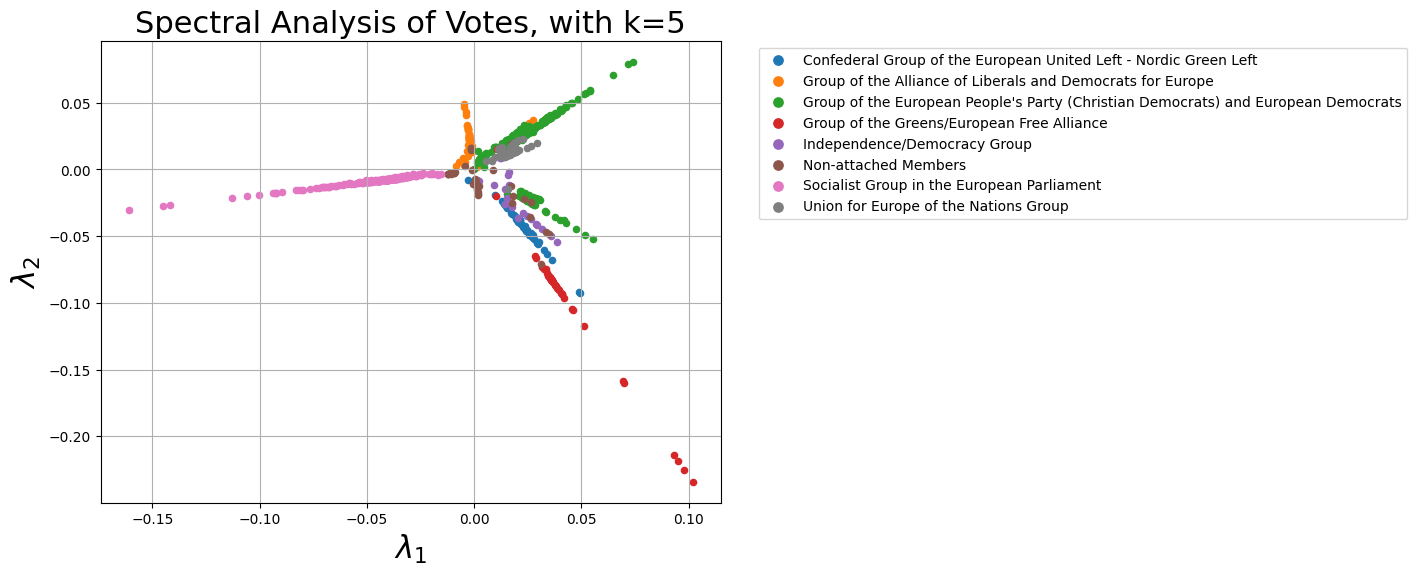

C:\Users\carls\AppData\Local\Temp\ipykernel_20848\3221537429.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("turbo", len(np.unique(country_labels)))


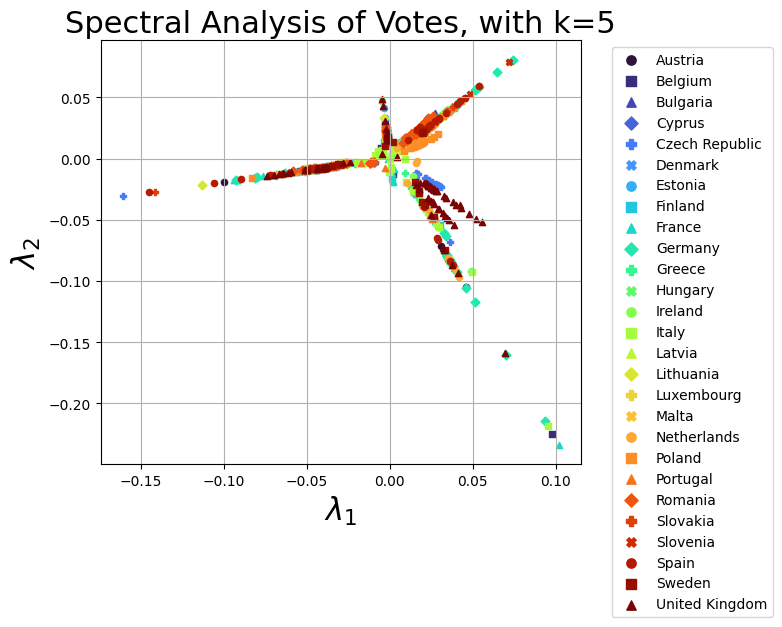

MDS summary for dataset: Spectral Analysis of Votes, with k=5
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


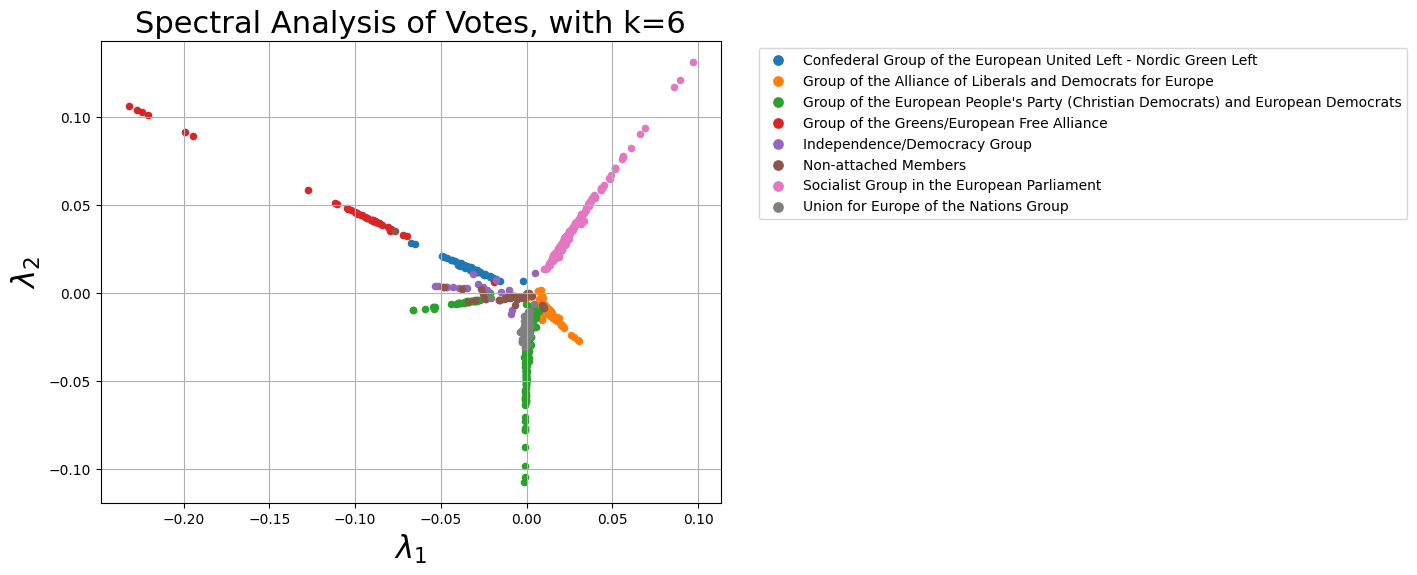

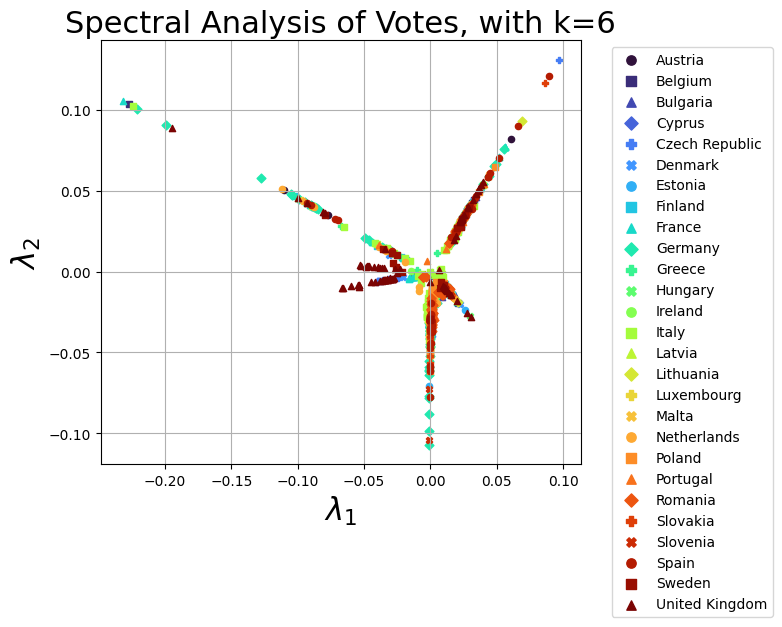

MDS summary for dataset: Spectral Analysis of Votes, with k=6
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


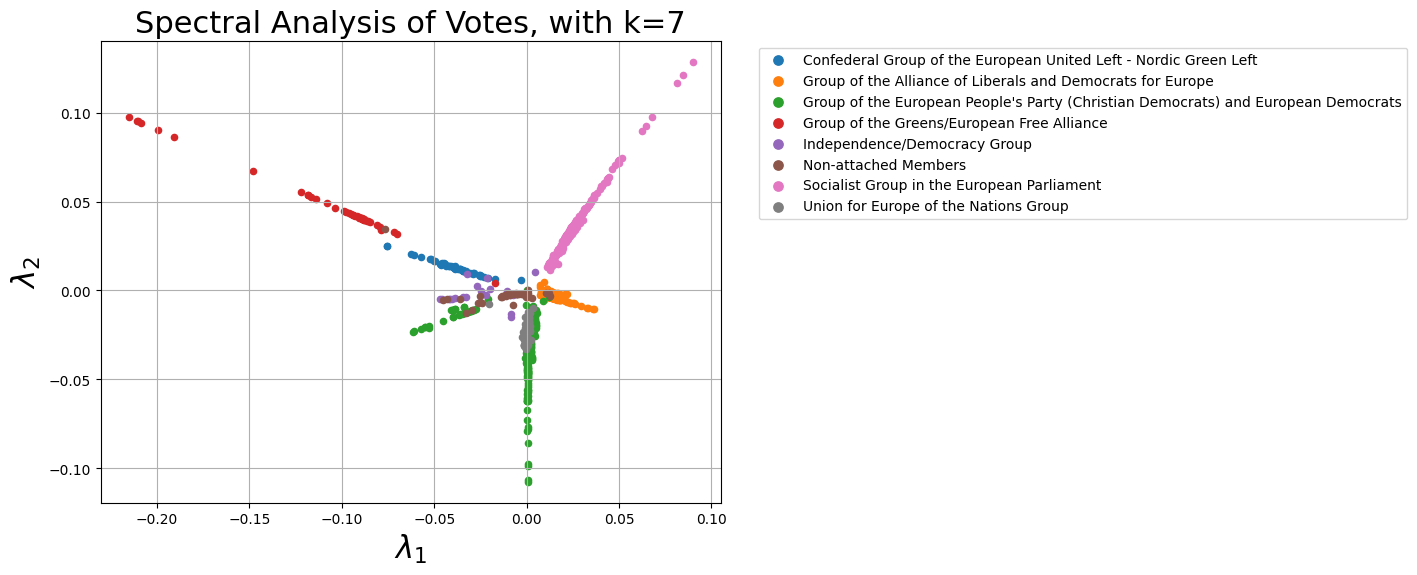

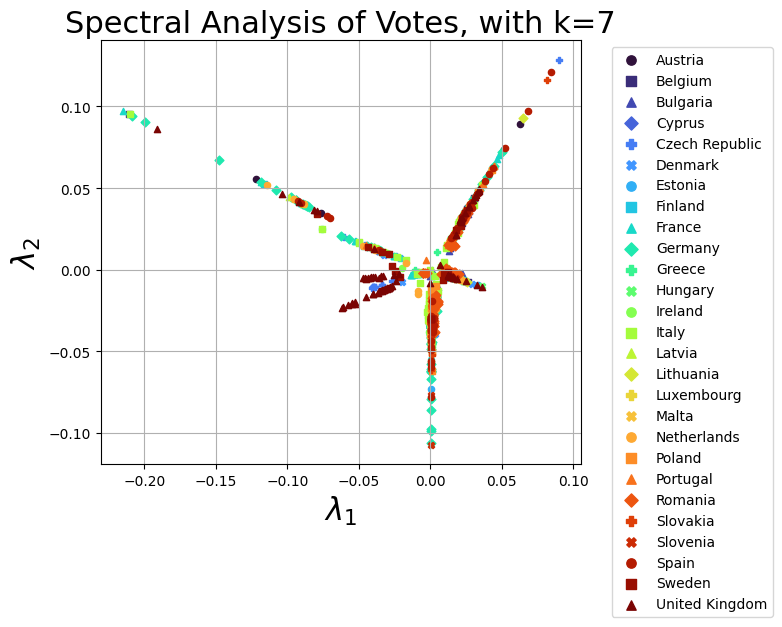

MDS summary for dataset: Spectral Analysis of Votes, with k=7
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


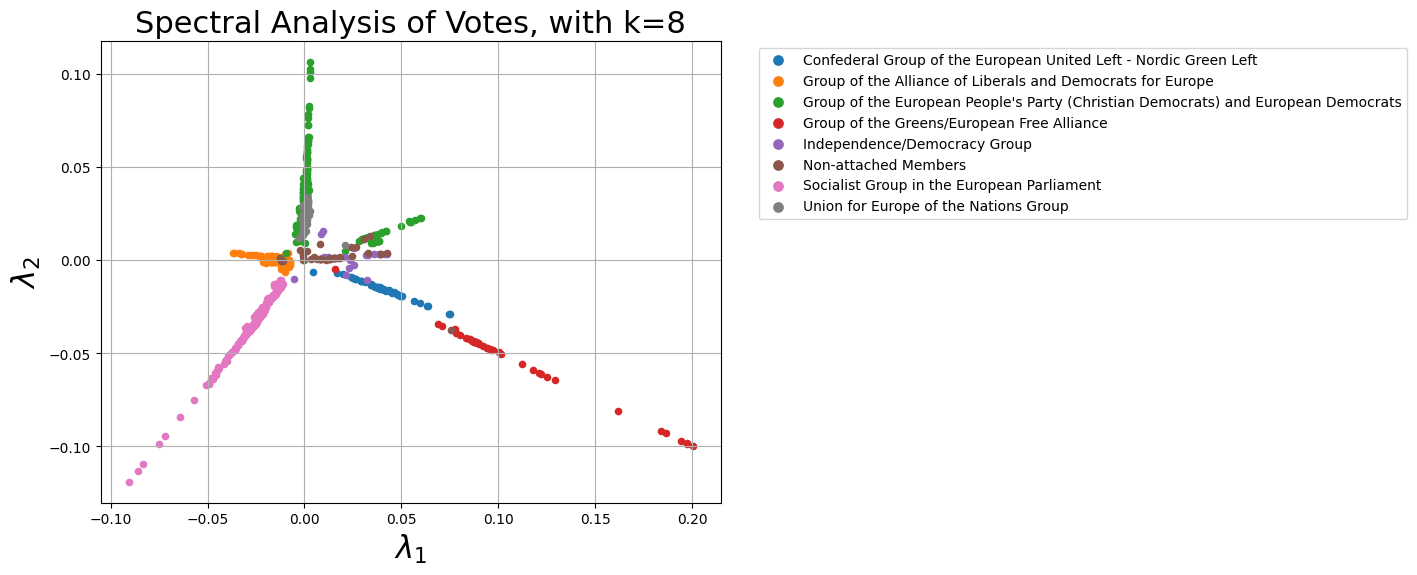

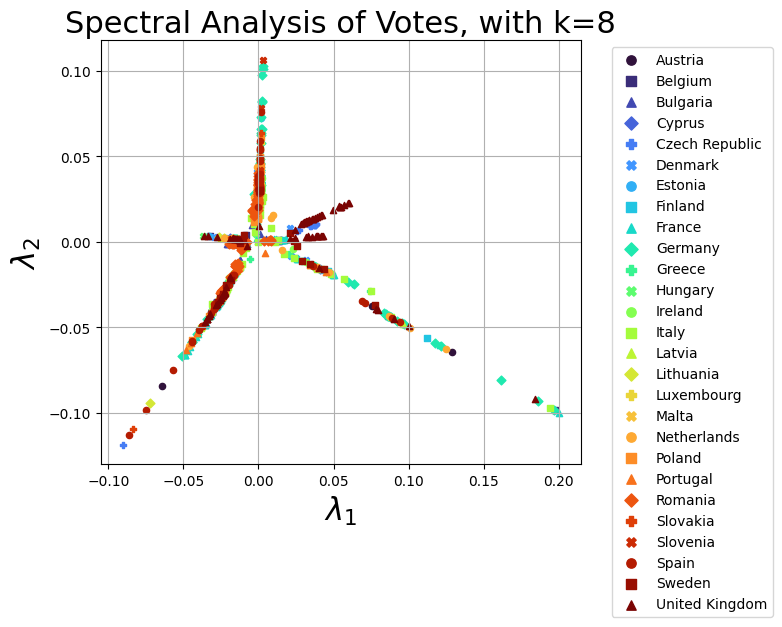

MDS summary for dataset: Spectral Analysis of Votes, with k=8
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


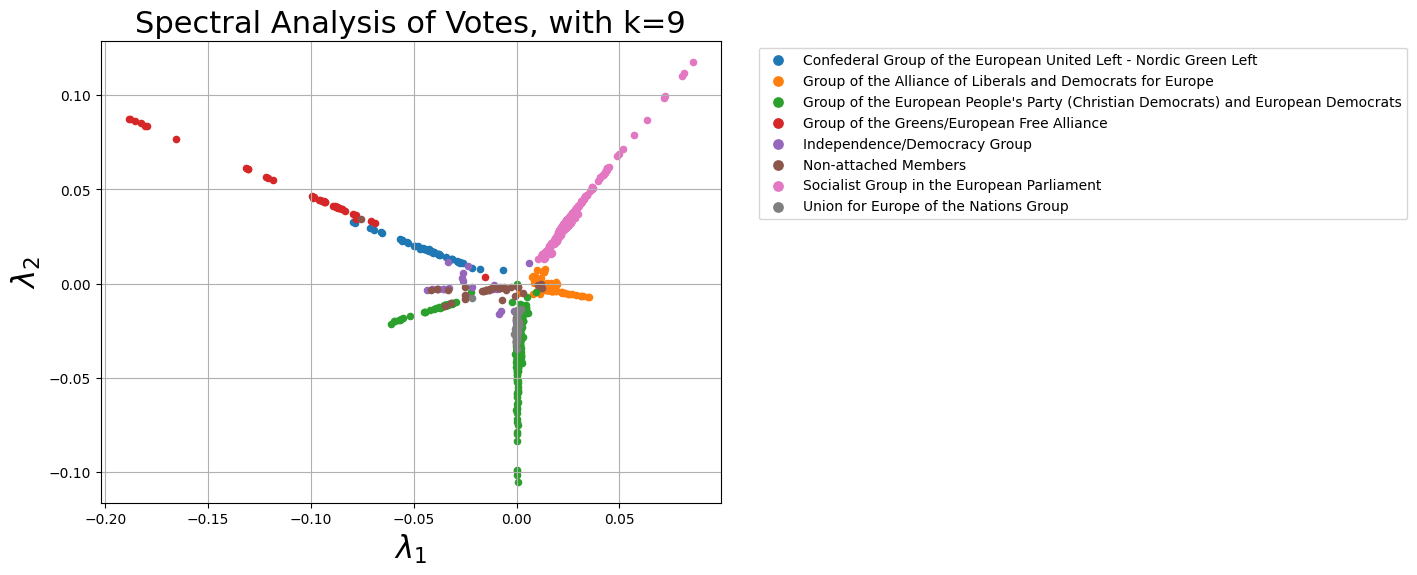

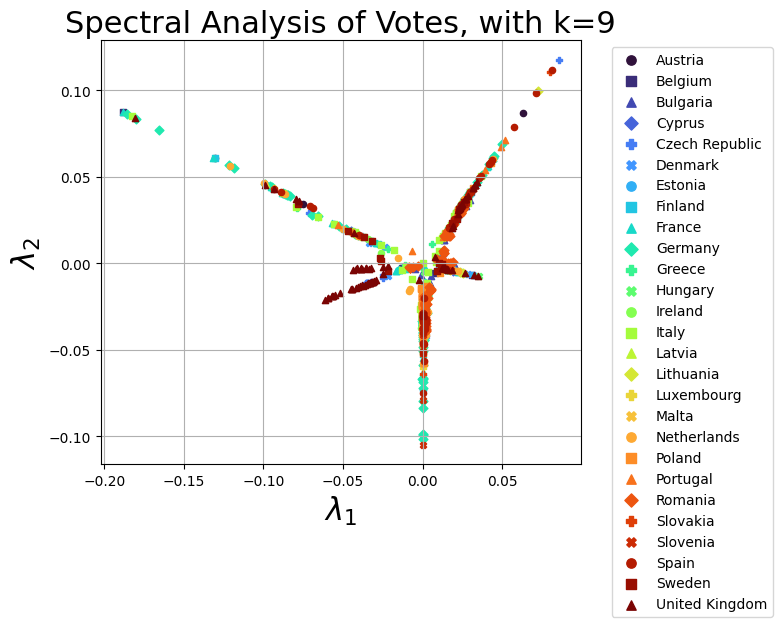

MDS summary for dataset: Spectral Analysis of Votes, with k=9
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


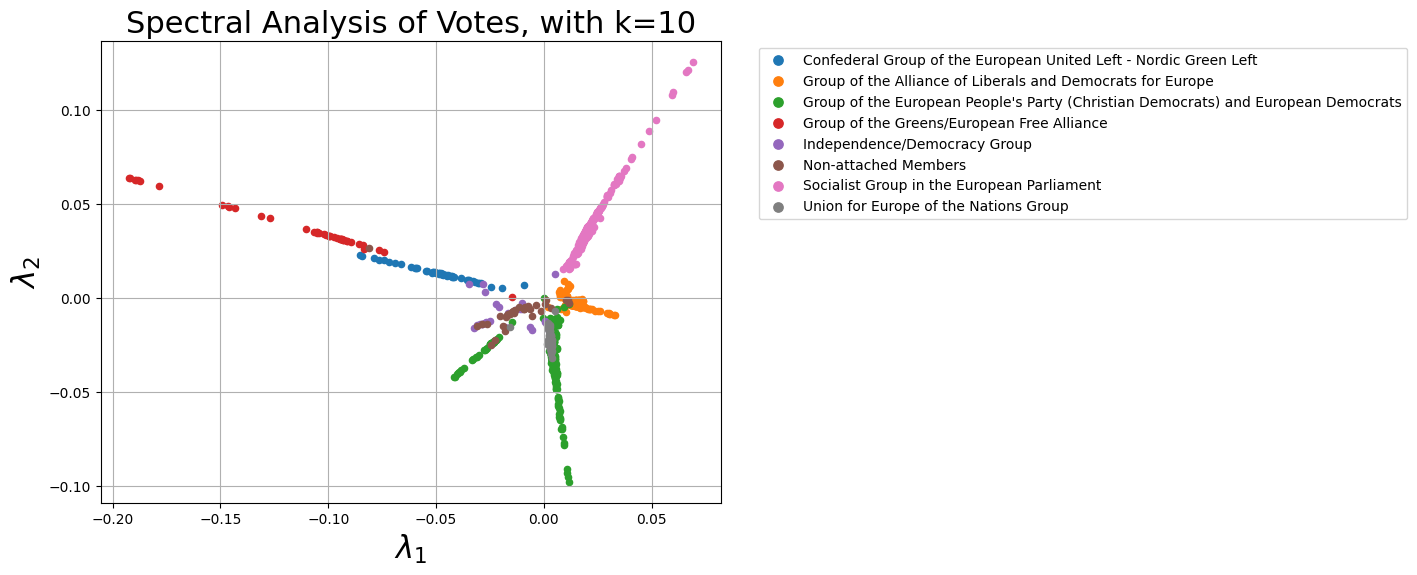

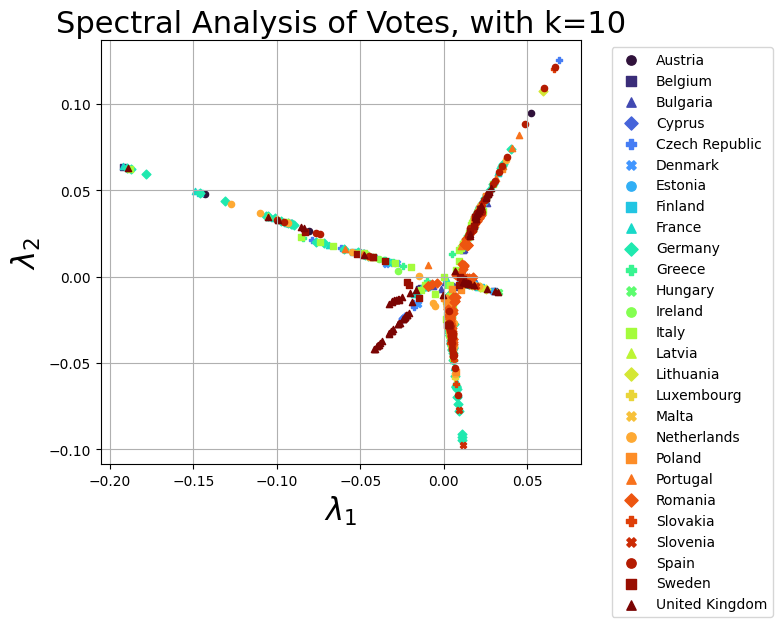

MDS summary for dataset: Spectral Analysis of Votes, with k=10
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


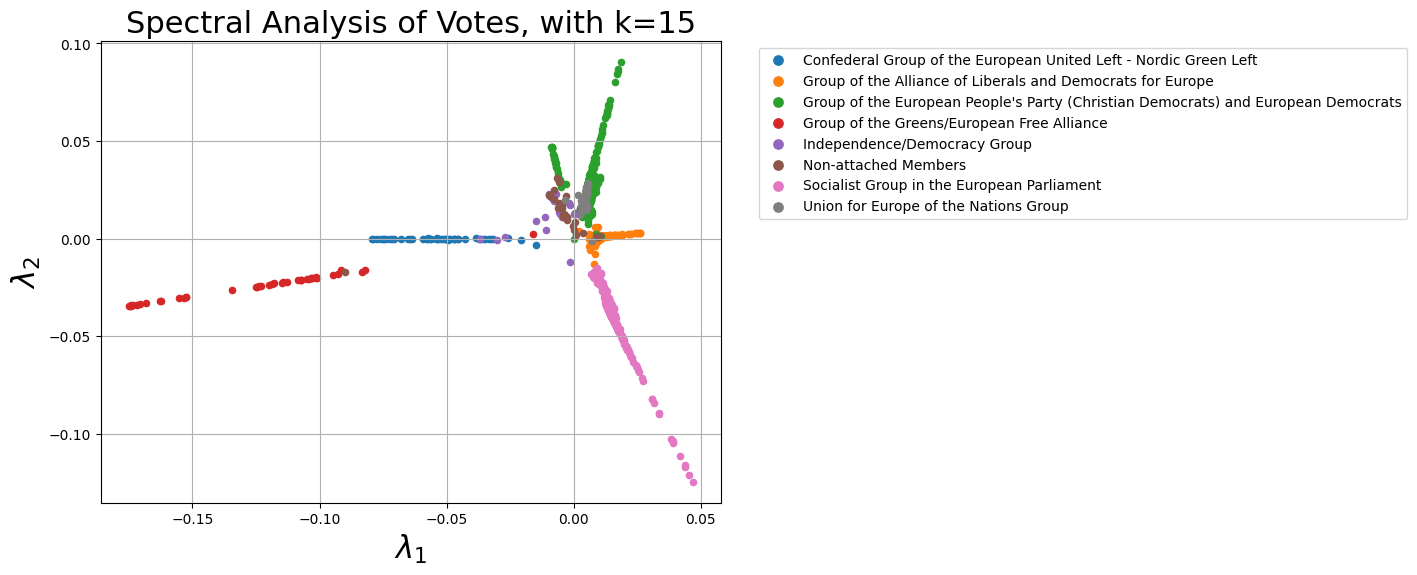

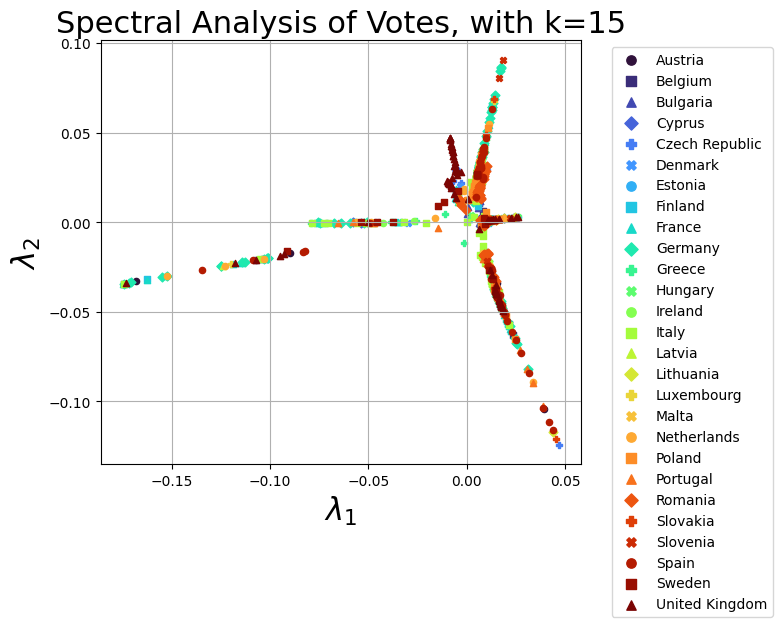

MDS summary for dataset: Spectral Analysis of Votes, with k=15
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 0.00%
Explained variance (MDS-2): 0.00%
Explained variance (1+2)  : 0.00%


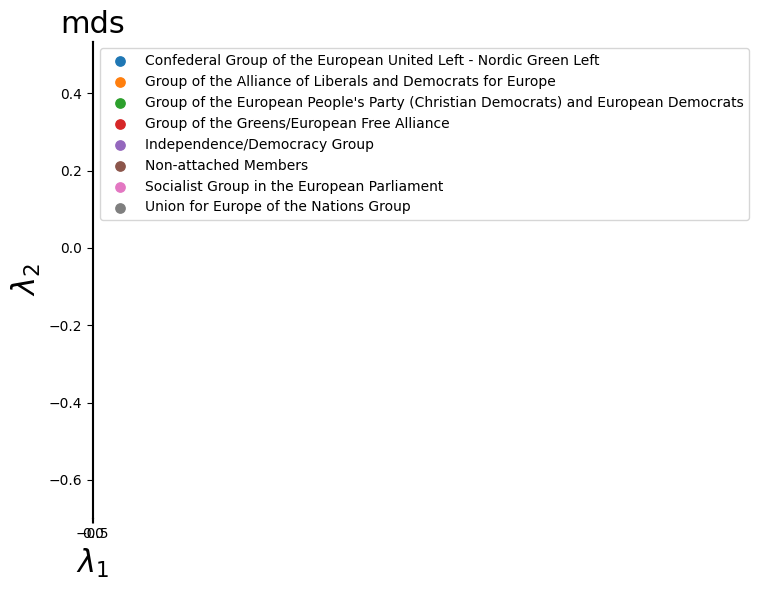

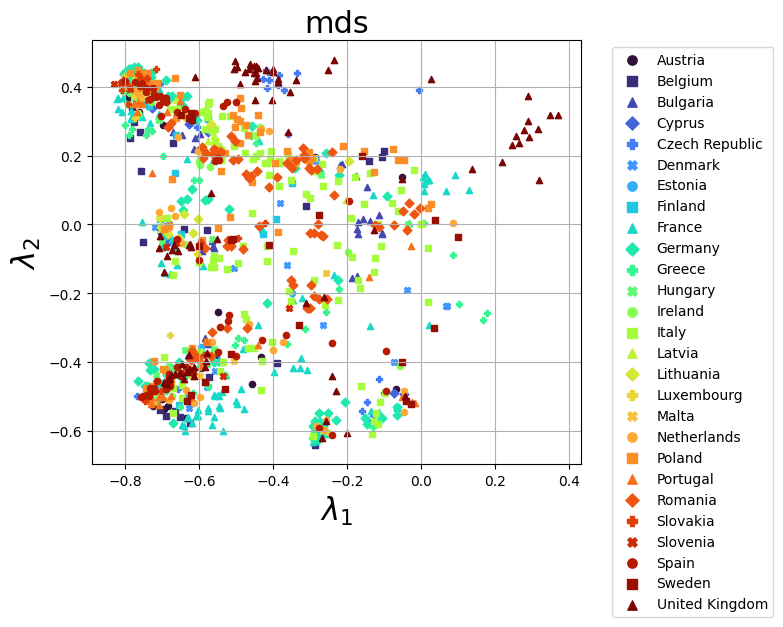

MDS summary for dataset: mds
------------------------------------------------------------
Number of MEPs           : 940
Explained variance (MDS-1): 30.47%
Explained variance (MDS-2): 12.54%
Explained variance (1+2)  : 43.01%


In [ ]:
import matplotlib.pyplot as plt


def plot_by_EPG(epg_labels, X, title="Plot", size=22, filename="plot_by_epg.png", save=False):

    plt.figure(figsize=(8, 6))
    if X.shape[1] == 2:
        for epg in np.unique(epg_labels):
            mask = epg_labels == epg
            plt.scatter(X[mask, 0], X[mask, 1], label=epg, s=20)
    else:
        for c in np.unique(epg_labels):
            mask = epg_labels == c
            plt.scatter(X[mask], np.zeros_like(X[mask]), label=c, s=20)

    plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc="upper left")
    #plt.xlim(-5, 5)

    plt.title(title, fontsize=size)
    plt.xlabel(r"$\lambda_1$", fontsize=size)
    plt.ylabel(r"$\lambda_2$", fontsize=size)
    plt.grid()
    plt.tight_layout()

    if save:
        plt.savefig(f"figures/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

def plot_by_country(country_labels, X, title="Plot", size=22, filename="plot_by_country.png", save=False):
    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap("turbo", len(np.unique(country_labels)))
    markers = ['o','s','^','D','P','X']
    n = len(markers)
    
    if X.shape[1] == 2:
        for i, c in enumerate(np.unique(country_labels)):
            mask = country_labels == c
            plt.scatter(X[mask, 0], X[mask, 1], label=c, s=20, color=cmap(i), marker=markers[i % n])

    else:
        for c in np.unique(country_labels):
            mask = country_labels == c
            plt.plot(X[mask], np.zeros_like(X[mask]), label=c, s=20)

    plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc="upper left")#, fontsize=18)
    plt.title(title, fontsize=size)
    plt.xlabel(r"$\lambda_1$", fontsize=size)
    plt.ylabel(r"$\lambda_2$", fontsize=size)
    plt.grid()
    plt.tight_layout()

    if save:
        plt.savefig(f"figures/{filename}", dpi=300, bbox_inches="tight")
    plt.show()


def explained_variance(evals, k=2):
    evals = np.asarray(evals)
    total = evals.sum()
    return evals[:k] / total

def print_mds_summary(name, X, evals):
    n_points = X.shape[0]
    explained = explained_variance(evals, k=2)

    print("=" * 60)
    print(f"MDS summary for dataset: {name}")
    print("-" * 60)
    print(f"Number of MEPs           : {n_points}")
    print(f"Explained variance (MDS-1): {explained[0]*100:.2f}%")
    print(f"Explained variance (MDS-2): {explained[1]*100:.2f}%")
    print(f"Explained variance (1+2)  : {(explained[:2].sum())*100:.2f}%")
    print("=" * 60)


def plot_results(result):
    colors = result["colors"]
    X = result["X"]
    name = str(result["name"])
    evals = result["evals"]

    epg_labels = colors["EPG"].to_numpy()
    plot_by_EPG(epg_labels, X,  title=name, filename=f"plot_by_epg_{name}.png", save=True)

    country_labels = colors["Country"].to_numpy()
    plot_by_country(country_labels, X, title=name, filename=f"plot_by_country_{name}.png", save=True)

    print_mds_summary(name, X, evals)

for k in ks:
    plot_results(res_ks[k])
#plot_results(means_result)
#plot_results(graph_result)
plot_results(result)
#for result in results:
#    plot_results(result)

""" Ignore the explanation of variance for the spectral plots, it only applies to the last MDS plot! """
